In [3]:
import random
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import warnings
warnings.filterwarnings('ignore')

InteractiveShell.ast_node_interactivity = "all"  # "last_expr"


%pylab inline
%matplotlib inline

np.random.seed(1)
np.set_printoptions(suppress=True, formatter={'float_kind': '{:0.5f}'.format})


#     %%writefile template.py
#     %load template.py - внешний файл

#     %lsmagic

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from sklearn.linear_model.base import BaseEstimator


class MyKnn_OLD(BaseEstimator):
    def __init__(self, n_neighbors=10,
                 kernel_name='cosine',
                 distance_name='euclidean',
                 encoding="label",
                 win_type="fixed"):
        self.n_neighbors = n_neighbors
        self.distance_name = distance_name
        self.kernel_name = kernel_name
        self.encoding = encoding
        self.win_type = win_type

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X_test):
        #         self.n_neighbors = min(self.n_neighbors, len(self._points))
        f_distance = group_distances(self.distance_name)
        f_kernel = group_kernels(self.kernel_name)

        print("params=[%s, %s, %s]" % (self.n_neighbors,
                                       self.distance_name,
                                       self.kernel_name))

        print(X_test.shape)
        print(self.X_train.shape)

        distances = f_distance(X_test, self.X_train)
        h = np.sort(distances, axis=1)[
            :, self.n_neighbors - 1] if win_type == "variable" else self.n_neighbors

        res_labels = []
        for _x in X_test:
            dists = [(f_distance(_x, self.points[i]), self.labels[i])
                     for i in range(len(self.points))]
            dists.sort()
            h = dists[self.n_neighbors - 1][0]
            if h == 0:
                res_labels.append(
                    round(sum([d[1] for d in dists])/len(dists)))
                continue
            num = 0
            den = 0
            for _d, _label in dists:
                weight = f_kernel(_d / h)
                num += _label * weight
                den += weight
            if den != 0:
                res_labels.append(round(num / den))
            else:
                res_labels.append(
                    round(sum([d[1] for d in dists])/len(dists)))
        return res_labels

In [ ]:
from sklearn.metrics import f1_score

splits_names = [ key for key in grid_cv.cv_results_.keys() if key.startswith("split")]
predictions = np.array([ grid_cv.cv_results_[split_name] for split_name in splits_names])
scores = []
for i in range(predictions.shape[1]):
    scores.append(f1_score(Y, predictions[:,i], average = "weighted"))
best_params = grid_cv.cv_results_["params"][np.argmax(scores)].copy()

In [ ]:
from sklearn.linear_model.base import BaseEstimator


class MyKnnR_OLD(BaseEstimator):
    def __init__(self, n_neighbors=10, kernel_name='cosine', distance_name='euclidean'):
        self.n_neighbors = n_neighbors
        self.distance_name = distance_name
        self.kernel_name = kernel_name

    def fit(self, X, Y):
        self.points = X
        self.labels = pd.get_dummies(pd.Series(list(Y))).values
#         return self

    def predict(self, _X):
        #         self.n_neighbors = min(self.n_neighbors, len(self._points))
        f_distance = group_distances(self.distance_name)
        f_kernel = group_kernels(self.kernel_name)

        print("params=[%s, %s, %s]" % (self.n_neighbors,
                                       self.distance_name,
                                       self.kernel_name))
        res_labels = []
        for _x in _X:
            dists = [(f_distance(_x, self.points[i]), self.labels[i])
                     for i in range(len(self.points))]
            dists.sort(key=lambda el: el[0])
            h = dists[self.n_neighbors - 1][0]
            if h == 0:
                res_labels.append(1)
                continue
            num = [0] * self.labels.shape[1]
            den = [0] * self.labels.shape[1]

            for _d, _labels in dists:
                weight = f_kernel(_d / h)
                for i in range(self.labels.shape[1]):
                    num[i] += _labels[i] * weight
                    den[i] += weight
            max_val = -1
            max_idx = -1
            for i in range(self.labels.shape[1]):
                if (den[i] == 0):
                    continue
                tmp_val = num[i] / den[i]
                if (tmp_val > max_val):
                    max_val = tmp_val
                    max_idx = i
            if max_idx != -1:
                res_labels.append(max_idx + 1)
            else:
                res_labels.append(1)
        return res_labels

In [212]:
from math import pi


def group_kernels(func_name: str):
    if func_name == 'uniform':
        return lambda u: np.where(np.abs(u) <= 1, 0.5, 0)
    elif func_name == 'triangular':
        return lambda u: np.where(np.abs(u) <= 1, 1 - np.abs(u), 0)
    elif func_name == 'epanechnikov':
        return lambda u: np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0)
    elif func_name == 'quartic':
        return lambda u: np.where(np.abs(u) <= 1, 15/16 * (1 - u**2)**2, 0)
    elif func_name == 'triweight':
        return lambda u: np.where(np.abs(u) <= 1, 35/32 * (1 - u**2)**3, 0)
    elif func_name == 'tricube':
        return lambda u: np.where(np.abs(u) <= 1, 70/81 * (1 - np.abs(u)**3)**3, 0)
    elif func_name == 'gaussian':
        return lambda u: 1/np.sqrt(2 * pi) * np.exp(-0.5 * u**2)
    elif func_name == 'cosine':
        return lambda u: np.where(np.abs(u) <= 1, pi / 4 * np.cos(pi / 2 * u), 0)
    elif func_name == 'logistic':
        return lambda u: 1 / (np.exp(u) + 2 + np.exp(-u))
    elif func_name == 'sigmoid':
        return lambda u: 2 / (pi*(np.exp(u) + np.exp(-u)))
    else:
        raise Exception("-_-")


def group_distances(func_name: str):
    if func_name == 'manhattan':
        return lambda x1, x2: np.abs(x1[:, None] - x2).sum(-1)
    elif func_name == 'euclidean':
        return lambda x1, x2: np.sqrt(np.sum((x1[:, None] - x2)**2, axis=-1))
    elif func_name == 'chebyshev':
        return lambda x1, x2: np.abs(x1[:, None] - x2).max(-1)
    else:
        raise Exception("_-_")

In [528]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder


class MyKnn(BaseEstimator):
    def __init__(self, n_neighbors=5,
                 kernel_name='cosine',
                 distance_name='euclidean',
                 encoding="label",
                 win_type="fixed"):
        self.n_neighbors = n_neighbors
        self.distance_name = distance_name
        self.kernel_name = kernel_name
        self.encoding = encoding
        self.win_type = win_type

    def fit(self, X, y):
        self.points_ = X
        self.labels_ = y
        return self

    def predict(self, X):
        print(
            "params=[%s, %s, %s, %s, %s]" % (
                self.n_neighbors,
                self.distance_name,
                self.kernel_name,
                self.encoding,
                self.win_type))
        
        if self.encoding == "label":
            encoder = LabelEncoder()
            transform_labels = encoder.fit_transform(self.labels_)
            predict = self.get_predict(X, transform_labels)
            predict = np.clip(
                np.round(predict), 0, len(
                    encoder.classes_) - 1).ravel().astype(int)
        else:
            encoder = OneHotEncoder()
            transform_labels = encoder.fit_transform(
                self.labels_[:, None]).toarray()
            predict = self.get_predict(X, transform_labels)
            predict = (predict == predict.max(
                axis=1)[:, None]).astype(int)
        return encoder.inverse_transform(predict).ravel()

    def get_predict(self, X_test, labels):
        distances = group_distances(self.distance_name)(X_test, self.points_)
#        print(h.shape)
        if self.win_type == "fixed":
            h = np.full((len(distances),), self.n_neighbors)
        else:
            h = np.sort(distances, axis=1)[:, self.n_neighbors - 1]

        result = np.zeros(
            (len(X_test), 1 if labels.ndim == 1 else labels.shape[1]))

        if (h != 0).any():
            weights = group_kernels(self.kernel_name)(
                distances[h != 0] / h[h != 0, None])
            labels = labels[:, None] if labels.ndim == 1 else labels
            num = (weights[:, :, None] * labels).sum(1)
            den = weights.sum(1)

            idx_0 = (h != 0)
            idx_0[idx_0 > 0] = (den == 0)
            result[idx_0] = labels.mean(axis=0)
            idx = (h != 0)
            idx[idx > 0] = (den != 0)
            result[idx] = num/den[:, None]

        return result

# Чтение, анализ и нормализация

In [546]:
df = pd.read_csv('dataset.csv', header=0, sep=',')
df = df.rename(columns={'OD280%2FOD315_of_diluted_wines': "diluted_wines"})
Y = df['class']
X = df.drop(['class'], axis=1)
X -= X.quantile(.5)
X /= (X.quantile(.95) - X.quantile(.5))

In [547]:
print("classes:", df['class'].unique())
print("shape:", df.shape)
print("nulls:", df.isnull().values.any())

classes: [1 2 3]
shape: (178, 14)
nulls: False


(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f40d7a87588>)

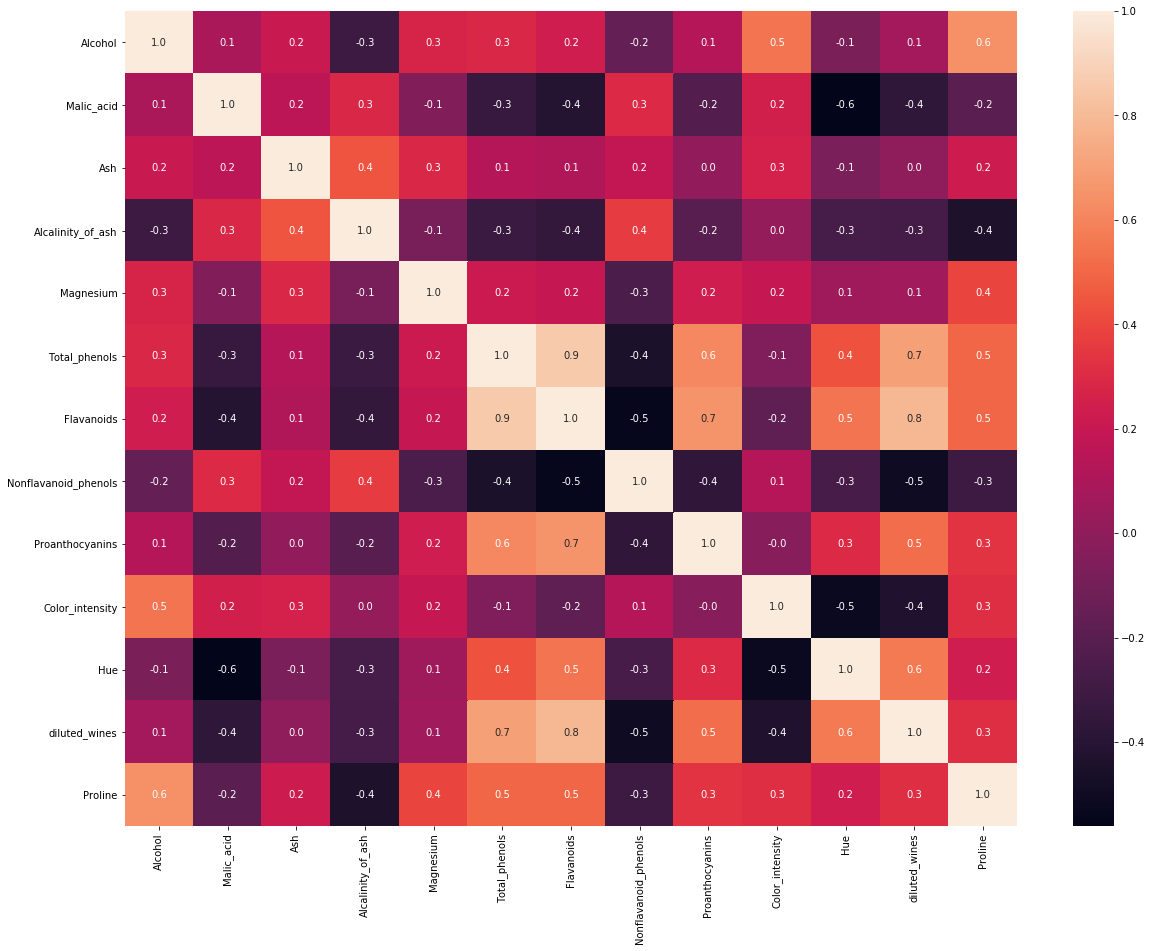

In [548]:
import seaborn as sns
plt.subplots(figsize=(20, 15))
sns.heatmap(X.corr(), annot=True, fmt='.1f', cbar=True)

In [549]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Alcalinity_of_ash     178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  diluted_wines         178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


In [550]:
MyKnn().get_params()

{'distance_name': 'euclidean',
 'encoding': 'label',
 'kernel_name': 'cosine',
 'n_neighbors': 5,
 'win_type': 'fixed'}

In [587]:
X = X.values
Y = Y.values

### --------------------------------------
# Наивный способ
### --------------------------------------

## От числа соседей

In [570]:
grid_param = {
    "n_neighbors": [1, 2, 3, 5, 7, 9],
    "distance_name": ["euclidean", "manhattan", "chebyshev"],
    "kernel_name": ["uniform", "triangular", "epanechnikov", "quartic", "triweight",
                    "tricube", "gaussian", "cosine", "logistic", "sigmoid"],
    "encoding": ["label"],
    "win_type": ["variable"]
}

In [571]:
from sklearn import model_selection
import sklearn.metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import make_scorer

scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average='macro') #weighted
grid_cv = model_selection.GridSearchCV(
    MyKnn(),
    grid_param,
#     n_jobs=-1,
    scoring=scorer,
    cv=LeaveOneOut())

In [572]:
%%time
grid_cv.fit(X, Y)

params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, variable]
params=[1, euclidean, uniform, label, va

params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, variable]
params=[2, euclidean, uniform, label, va

params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, variable]
params=[3, euclidean, uniform, label, va

params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, variable]
params=[7, euclidean, uniform, label, va

params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, variable]
params=[9, euclidean, uniform, label, va

params=[1, euclidean, triangular, label, variable]
params=[1, euclidean, triangular, label, variable]
params=[1, euclidean, triangular, label, variable]
params=[1, euclidean, triangular, label, variable]
params=[1, euclidean, triangular, label, variable]
params=[1, euclidean, triangular, label, variable]
params=[1, euclidean, triangular, label, variable]
params=[1, euclidean, triangular, label, variable]
params=[1, euclidean, triangular, label, variable]
params=[1, euclidean, triangular, label, variable]
params=[1, euclidean, triangular, label, variable]
params=[2, euclidean, triangular, label, variable]
params=[2, euclidean, triangular, label, variable]
params=[2, euclidean, triangular, label, variable]
params=[2, euclidean, triangular, label, variable]
params=[2, euclidean, triangular, label, variable]
params=[2, euclidean, triangular, label, variable]
params=[2, euclidean, triangular, label, variable]
params=[2, euclidean, triangular, label, variable]
params=[2, euclidean, triangula

params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangular, label, variable]
params=[3, euclidean, triangula

params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangular, label, variable]
params=[5, euclidean, triangula

params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangular, label, variable]
params=[7, euclidean, triangula

params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, variable]
params=[1, euclidean, epanechnikov, label, var

params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, variable]
params=[2, euclidean, epanechnikov, label, var

params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[3, euclidean, epanechnikov, label, variable]
params=[5, euclidean, epanechnikov, label, variable]
params=[5, euclidean, epanechnikov, label, variable]
params=[5, euclidean, epanechnikov, label, variable]
params=[5, euclidean, epanechnikov, label, variable]
params=[5, euclidean, epanechnikov, label, variable]
params=[5, euclidean, epanechnikov, label, variable]
params=[5, euclidean, epanechnikov, label, var

params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, variable]
params=[7, euclidean, epanechnikov, label, var

params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, variable]
params=[9, euclidean, epanechnikov, label, var

params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, variable]
params=[2, euclidean, quartic, label, va

params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, variable]
params=[3, euclidean, quartic, label, va

params=[5, euclidean, quartic, label, variable]
params=[5, euclidean, quartic, label, variable]
params=[5, euclidean, quartic, label, variable]
params=[5, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, variable]
params=[7, euclidean, quartic, label, va

params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, variable]
params=[9, euclidean, quartic, label, va

params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]
params=[1, euclidean, triweight, label, variable]


params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]
params=[2, euclidean, triweight, label, variable]


params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]
params=[5, euclidean, triweight, label, variable]


params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]
params=[7, euclidean, triweight, label, variable]


params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]
params=[9, euclidean, triweight, label, variable]


params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, variable]
params=[2, euclidean, tricube, label, va

params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, variable]
params=[3, euclidean, tricube, label, va

params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, variable]
params=[5, euclidean, tricube, label, va

params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, variable]
params=[9, euclidean, tricube, label, va

params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean, gaussian, label, variable]
params=[1, euclidean

params=[2, euclidean, gaussian, label, variable]
params=[2, euclidean, gaussian, label, variable]
params=[2, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean, gaussian, label, variable]
params=[3, euclidean

params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean, gaussian, label, variable]
params=[5, euclidean

params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean, gaussian, label, variable]
params=[7, euclidean

params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, euclidean, cosine, label, variable]
params=[1, eu

params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, euclidean, cosine, label, variable]
params=[2, eu

params=[3, euclidean, cosine, label, variable]
params=[3, euclidean, cosine, label, variable]
params=[3, euclidean, cosine, label, variable]
params=[3, euclidean, cosine, label, variable]
params=[3, euclidean, cosine, label, variable]
params=[3, euclidean, cosine, label, variable]
params=[3, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, euclidean, cosine, label, variable]
params=[5, eu

params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, euclidean, cosine, label, variable]
params=[7, eu

params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, euclidean, cosine, label, variable]
params=[9, eu

params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean, logistic, label, variable]
params=[2, euclidean

params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean, logistic, label, variable]
params=[3, euclidean

params=[5, euclidean, logistic, label, variable]
params=[5, euclidean, logistic, label, variable]
params=[5, euclidean, logistic, label, variable]
params=[5, euclidean, logistic, label, variable]
params=[5, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean, logistic, label, variable]
params=[7, euclidean

params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean, logistic, label, variable]
params=[9, euclidean

params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, variable]
params=[1, euclidean, sigmoid, label, va

params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, variable]
params=[3, euclidean, sigmoid, label, va

params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, variable]
params=[5, euclidean, sigmoid, label, va

params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, variable]
params=[9, euclidean, sigmoid, label, va

params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, va

params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, va

params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, va

params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, va

params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangular, label, variable]
params=[1, manhattan, triangula

params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangular, label, variable]
params=[3, manhattan, triangula

params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangular, label, variable]
params=[5, manhattan, triangula

params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangular, label, variable]
params=[7, manhattan, triangula

params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, variable]
params=[1, manhattan, epanechnikov, label, var

params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, variable]
params=[2, manhattan, epanechnikov, label, var

params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, variable]
params=[5, manhattan, epanechnikov, label, var

params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, variable]
params=[7, manhattan, epanechnikov, label, var

params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, variable]
params=[1, manhattan, quartic, label, va

params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, variable]
params=[2, manhattan, quartic, label, va

params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, variable]
params=[5, manhattan, quartic, label, va

params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, variable]
params=[7, manhattan, quartic, label, va

params=[9, manhattan, quartic, label, variable]
params=[9, manhattan, quartic, label, variable]
params=[9, manhattan, quartic, label, variable]
params=[9, manhattan, quartic, label, variable]
params=[9, manhattan, quartic, label, variable]
params=[9, manhattan, quartic, label, variable]
params=[9, manhattan, quartic, label, variable]
params=[9, manhattan, quartic, label, variable]
params=[9, manhattan, quartic, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhattan, triweight, label, variable]
params=[1, manhatt

params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]
params=[2, manhattan, triweight, label, variable]


params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]
params=[3, manhattan, triweight, label, variable]


params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]
params=[7, manhattan, triweight, label, variable]


params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]
params=[9, manhattan, triweight, label, variable]


params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, variable]
params=[2, manhattan, tricube, label, va

params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, variable]
params=[3, manhattan, tricube, label, va

params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, variable]
params=[5, manhattan, tricube, label, va

params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, variable]
params=[9, manhattan, tricube, label, va

params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan, gaussian, label, variable]
params=[1, manhattan

params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan, gaussian, label, variable]
params=[3, manhattan

params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan, gaussian, label, variable]
params=[5, manhattan

params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan, gaussian, label, variable]
params=[9, manhattan

params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, manhattan, cosine, label, variable]
params=[1, ma

params=[2, manhattan, cosine, label, variable]
params=[2, manhattan, cosine, label, variable]
params=[2, manhattan, cosine, label, variable]
params=[2, manhattan, cosine, label, variable]
params=[2, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, manhattan, cosine, label, variable]
params=[3, ma

params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, manhattan, cosine, label, variable]
params=[5, ma

params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, manhattan, cosine, label, variable]
params=[7, ma

params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan, logistic, label, variable]
params=[1, manhattan

params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan, logistic, label, variable]
params=[2, manhattan

params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan, logistic, label, variable]
params=[5, manhattan

params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan, logistic, label, variable]
params=[7, manhattan

params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, variable]
params=[1, manhattan, sigmoid, label, va

params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, variable]
params=[2, manhattan, sigmoid, label, va

params=[3, manhattan, sigmoid, label, variable]
params=[3, manhattan, sigmoid, label, variable]
params=[3, manhattan, sigmoid, label, variable]
params=[3, manhattan, sigmoid, label, variable]
params=[3, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, variable]
params=[5, manhattan, sigmoid, label, va

params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, variable]
params=[7, manhattan, sigmoid, label, va

params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[9, manhattan, sigmoid, label, variable]
params=[1, chebyshev, uniform, label, variable]
params=[1, chebyshev, uniform, label, va

params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, variable]
params=[2, chebyshev, uniform, label, va

params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, variable]
params=[3, chebyshev, uniform, label, va

params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, variable]
params=[7, chebyshev, uniform, label, va

params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, variable]
params=[9, chebyshev, uniform, label, va

params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangular, label, variable]
params=[2, chebyshev, triangula

params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangular, label, variable]
params=[3, chebyshev, triangula

params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangular, label, variable]
params=[7, chebyshev, triangula

params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangular, label, variable]
params=[9, chebyshev, triangula

params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, variable]
params=[1, chebyshev, epanechnikov, label, var

params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, variable]
params=[3, chebyshev, epanechnikov, label, var

params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, variable]
params=[5, chebyshev, epanechnikov, label, var

params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, variable]
params=[9, chebyshev, epanechnikov, label, var

params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, variable]
params=[1, chebyshev, quartic, label, va

params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, variable]
params=[3, chebyshev, quartic, label, va

params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, variable]
params=[5, chebyshev, quartic, label, va

params=[7, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, variable]
params=[9, chebyshev, quartic, label, va

params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]
params=[1, chebyshev, triweight, label, variable]


params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]
params=[2, chebyshev, triweight, label, variable]


params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]
params=[5, chebyshev, triweight, label, variable]


params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]
params=[7, chebyshev, triweight, label, variable]


params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, variable]
params=[1, chebyshev, tricube, label, va

params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, variable]
params=[2, chebyshev, tricube, label, va

params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[3, chebyshev, tricube, label, variable]
params=[5, chebyshev, tricube, label, variable]
params=[5, chebyshev, tricube, label, variable]
params=[5, chebyshev, tricube, label, variable]
params=[5, chebyshev, tricube, label, variable]
params=[5, chebyshev, tricube, label, variable]
params=[5, chebyshev, tricube, label, variable]
params=[5, chebyshev, tricube, label, variable]
params=[5, chebyshev, tricube, label, variable]
params=[5, chebyshev, tricube, label, va

params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, variable]
params=[7, chebyshev, tricube, label, va

params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, variable]
params=[9, chebyshev, tricube, label, va

params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev, gaussian, label, variable]
params=[2, chebyshev

params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev, gaussian, label, variable]
params=[3, chebyshev

params=[5, chebyshev, gaussian, label, variable]
params=[5, chebyshev, gaussian, label, variable]
params=[5, chebyshev, gaussian, label, variable]
params=[5, chebyshev, gaussian, label, variable]
params=[5, chebyshev, gaussian, label, variable]
params=[5, chebyshev, gaussian, label, variable]
params=[5, chebyshev, gaussian, label, variable]
params=[5, chebyshev, gaussian, label, variable]
params=[5, chebyshev, gaussian, label, variable]
params=[5, chebyshev, gaussian, label, variable]
params=[7, chebyshev, gaussian, label, variable]
params=[7, chebyshev, gaussian, label, variable]
params=[7, chebyshev, gaussian, label, variable]
params=[7, chebyshev, gaussian, label, variable]
params=[7, chebyshev, gaussian, label, variable]
params=[7, chebyshev, gaussian, label, variable]
params=[7, chebyshev, gaussian, label, variable]
params=[7, chebyshev, gaussian, label, variable]
params=[7, chebyshev, gaussian, label, variable]
params=[7, chebyshev, gaussian, label, variable]
params=[7, chebyshev

params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev, gaussian, label, variable]
params=[9, chebyshev

params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, chebyshev, cosine, label, variable]
params=[1, ch

params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, chebyshev, cosine, label, variable]
params=[3, ch

params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, chebyshev, cosine, label, variable]
params=[5, ch

params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, chebyshev, cosine, label, variable]
params=[7, ch

params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev, logistic, label, variable]
params=[1, chebyshev

params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev, logistic, label, variable]
params=[2, chebyshev

params=[3, chebyshev, logistic, label, variable]
params=[3, chebyshev, logistic, label, variable]
params=[3, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev, logistic, label, variable]
params=[5, chebyshev

params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev, logistic, label, variable]
params=[7, chebyshev

params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev, logistic, label, variable]
params=[9, chebyshev

params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, variable]
params=[2, chebyshev, sigmoid, label, va

params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, variable]
params=[3, chebyshev, sigmoid, label, va

params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, variable]
params=[5, chebyshev, sigmoid, label, va

params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, variable]
params=[9, chebyshev, sigmoid, label, va

GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='cosine', n_neighbors=5,
                             win_type='fixed'),
             iid='deprecated', n_jobs=None,
             param_grid={'distance_name': ['euclidean', 'manhattan',
                                           'chebyshev'],
                         'encoding': ['label'],
                         'kernel_name': ['uniform', 'triangular',
                                         'epanechnikov', 'quartic', 'triweight',
                                         'tricube', 'gaussian', 'cosine',
                                         'logistic', 'sigmoid'],
                         'n_neighbors': [1, 2, 3, 5, 7, 9],
                         'win_type': ['variable']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=0)

In [573]:
grid_cv.best_params_
grid_cv.best_score_

{'distance_name': 'manhattan',
 'encoding': 'label',
 'kernel_name': 'uniform',
 'n_neighbors': 1,
 'win_type': 'variable'}

0.8426966292134831

## От ширины окна

In [566]:
grid_param = {
    "n_neighbors": np.arange(0.05, 0.5, 0.05),
    "distance_name": ["euclidean", "manhattan", "chebyshev"],
    "kernel_name": ["uniform", "triangular", "epanechnikov", "quartic", "triweight",
                    "tricube", "gaussian", "cosine", "logistic", "sigmoid"],
    "encoding": ["label"],
    "win_type": ["fixed"]
}

In [567]:
from sklearn import model_selection
import sklearn.metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import make_scorer

scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average='macro') #weighted
grid_cv = model_selection.GridSearchCV(
    MyKnn(),
    grid_param,
#     n_jobs=-1,
    scoring=scorer,
    cv=LeaveOneOut())

In [568]:
%%time
grid_cv.fit(X, Y)

params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label, fixed]
params=[0.05, euclidean, uniform, label,

params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, euclidean, uniform, label, fixed]
params=[0.1, 

params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label, fixed]
params=[0.15000000000000002, euclidean, uniform, label,

params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label, fixed]
params=[0.25, euclidean, uniform, label,

params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, euclidean, uniform, label, fixed]
params=[0.3, 

params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label, fixed]
params=[0.35000000000000003, euclidean, uniform, label,

params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label, fixed]
params=[0.45, euclidean, uniform, label,

params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triangular, label, fixed]
params=[0.05, euclidean, triang

params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.

params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.15000000000000002, euclidean, triangular, label, fixed]
params=[0.

params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triangular, label, fixed]
params=[0.25, euclidean, triang

params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]
params=[0.3, euclidean, triangular, label, fixed]


params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]
params=[0.4, euclidean, triangular, label, fixed]


params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triangular, label, fixed]
params=[0.45, euclidean, triang

params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.05, euclidean, epanechnikov, label, fixed]
params=[0.1, euclidean, epanechnikov, label, fixed]
params=[0.1, euclidean, epanechnikov, label, fixed]
params=[0.1, euclidean, epanechnikov, label, fixed]
params=[0.1, euclidean, epanechnikov, label, fixed]
params=[0.1, euclidean, epanechnikov, label, fixed

params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, label, fixed]
params=[0.15000000000000002, euclidean, epanechn

params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2, euclidean, epanechnikov, label, fixed]
params=[0.2,

params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, fixed]
params=[0.25, euclidean, epanechnikov, label, 

params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3, euclidean, epanechnikov, label, fixed]
params=[0.3,

params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, label, fixed]
params=[0.35000000000000003, euclidean, epanechn

params=[0.4, euclidean, epanechnikov, label, fixed]
params=[0.4, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fixed]
params=[0.45, euclidean, epanechnikov, label, fi

params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label, fixed]
params=[0.05, euclidean, quartic, label,

params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, euclidean, quartic, label, fixed]
params=[0.1, 

params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, euclidean, quartic, label, fixed]
params=[0.2, 

params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label, fixed]
params=[0.25, euclidean, quartic, label,

params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label, fixed]
params=[0.35000000000000003, euclidean, quartic, label,

params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, euclidean, quartic, label, fixed]
params=[0.4, 

params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label, fixed]
params=[0.45, euclidean, quartic, label,

params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclidean, triweight, label, fixed]
params=[0.1, euclide

params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.15000000000000002, euclidean, triweight, label, fixed]
params=[0.150000000000000

params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.2, euclidean, triweight, label, fixed]
params=[0.25, euclidean, triweight, label, fixed]
params=[0.25, euclidean, triweight, label, fixed]
params=[0.25, euclidean, triweight, label, fixed]
params=[0.25, euclidean, triweight, label, fixed]
params=[0.25, euclidean, triweight, label, fixed]
params=[0.25, euclidean, triweight, label, fixed]
params=[0.25, 

params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclidean, triweight, label, fixed]
params=[0.3, euclide

params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.35000000000000003, euclidean, triweight, label, fixed]
params=[0.350000000000000

params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]
params=[0.45, euclidean, triweight, label, fixed]


params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label, fixed]
params=[0.05, euclidean, tricube, label,

params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, euclidean, tricube, label, fixed]
params=[0.1, 

params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, euclidean, tricube, label, fixed]
params=[0.2, 

params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label, fixed]
params=[0.25, euclidean, tricube, label,

params=[0.3, euclidean, tricube, label, fixed]
params=[0.3, euclidean, tricube, label, fixed]
params=[0.3, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, tricube, label, fixed]
params=[0.35000000000000003, euclidean, 

params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, euclidean, tricube, label, fixed]
params=[0.4, 

params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label, fixed]
params=[0.45, euclidean, tricube, label,

params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label, fixed]
params=[0.1, euclidean, gaussian, label,

params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, gaussian, label, fixed]
params=[0.15000000000000002, euclidean, 

params=[0.2, euclidean, gaussian, label, fixed]
params=[0.2, euclidean, gaussian, label, fixed]
params=[0.2, euclidean, gaussian, label, fixed]
params=[0.2, euclidean, gaussian, label, fixed]
params=[0.2, euclidean, gaussian, label, fixed]
params=[0.2, euclidean, gaussian, label, fixed]
params=[0.2, euclidean, gaussian, label, fixed]
params=[0.2, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gaussian, label, fixed]
params=[0.25, euclidean, gau

params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label, fixed]
params=[0.3, euclidean, gaussian, label,

params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, gaussian, label, fixed]
params=[0.35000000000000003, euclidean, 

params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclidean, gaussian, label, fixed]
params=[0.45, euclid

params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05, euclidean, cosine, label, fixed]
params=[0.05,

params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[0.15000000000000002, euclidean, cosine, label, fixed]
params=[

params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, label, fixed]
params=[0.2, euclidean, cosine, la

params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25, euclidean, cosine, label, fixed]
params=[0.25,

params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[0.35000000000000003, euclidean, cosine, label, fixed]
params=[

params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, label, fixed]
params=[0.4, euclidean, cosine, la

params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclidean, logistic, label, fixed]
params=[0.05, euclid

params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label, fixed]
params=[0.1, euclidean, logistic, label,

params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.15000000000000002, euclidean, logistic, label, fixed]
params=[0.2, euclidean, logistic, label, fixed]
params=[0.2, euclidean, logistic, label, fixed]
params=[0.2, euclidean, logistic, label, fixed]
params=[0.2, euclidean, logistic, label, fixed]
params=[0.2, euclidean, logistic, label, fixed]
params=[0.2, euclidean, logistic, label, fixed]
params=[

params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclidean, logistic, label, fixed]
params=[0.25, euclid

params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label, fixed]
params=[0.3, euclidean, logistic, label,

params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label, fixed]
params=[0.4, euclidean, logistic, label,

params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclidean, logistic, label, fixed]
params=[0.45, euclid

params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, euclidean, sigmoid, label, fixed]
params=[0.1, 

params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label, fixed]
params=[0.15000000000000002, euclidean, sigmoid, label,

params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.2, euclidean, sigmoid, label, fixed]
params=[0.25,

params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, euclidean, sigmoid, label, fixed]
params=[0.3, 

params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label, fixed]
params=[0.35000000000000003, euclidean, sigmoid, label,

params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label, fixed]
params=[0.45, euclidean, sigmoid, label,

params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label, fixed]
params=[0.05, manhattan, uniform, label,

params=[0.1, manhattan, uniform, label, fixed]
params=[0.1, manhattan, uniform, label, fixed]
params=[0.1, manhattan, uniform, label, fixed]
params=[0.1, manhattan, uniform, label, fixed]
params=[0.1, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0.15000000000000002, manhattan, uniform, label, fixed]
params=[0

params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, manhattan, uniform, label, fixed]
params=[0.2, 

params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label, fixed]
params=[0.25, manhattan, uniform, label,

params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label, fixed]
params=[0.35000000000000003, manhattan, uniform, label,

params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, manhattan, uniform, label, fixed]
params=[0.4, 

params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triangular, label, fixed]
params=[0.05, manhattan, triang

params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]
params=[0.1, manhattan, triangular, label, fixed]


params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]
params=[0.2, manhattan, triangular, label, fixed]


params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triangular, label, fixed]
params=[0.25, manhattan, triang

params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]
params=[0.3, manhattan, triangular, label, fixed]


params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]
params=[0.4, manhattan, triangular, label, fixed]


params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triangular, label, fixed]
params=[0.45, manhattan, triang

params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1, manhattan, epanechnikov, label, fixed]
params=[0.1,

params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, label, fixed]
params=[0.15000000000000002, manhattan, epanechn

params=[0.2, manhattan, epanechnikov, label, fixed]
params=[0.2, manhattan, epanechnikov, label, fixed]
params=[0.2, manhattan, epanechnikov, label, fixed]
params=[0.2, manhattan, epanechnikov, label, fixed]
params=[0.2, manhattan, epanechnikov, label, fixed]
params=[0.2, manhattan, epanechnikov, label, fixed]
params=[0.2, manhattan, epanechnikov, label, fixed]
params=[0.2, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
params=[0.25, manhattan, epanechnikov, label, fixed]
p

params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3, manhattan, epanechnikov, label, fixed]
params=[0.3,

params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, label, fixed]
params=[0.35000000000000003, manhattan, epanechn

params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, fixed]
params=[0.45, manhattan, epanechnikov, label, 

params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label, fixed]
params=[0.05, manhattan, quartic, label,

params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label, fixed]
params=[0.15000000000000002, manhattan, quartic, label,

params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, manhattan, quartic, label, fixed]
params=[0.2, 

params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.25, manhattan, quartic, label, fixed]
params=[0.3, manhattan, quartic, label, fixed]
params=[0.3, manhattan, quartic, label, f

params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label, fixed]
params=[0.35000000000000003, manhattan, quartic, label,

params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, manhattan, quartic, label, fixed]
params=[0.4, 

params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]
params=[0.05, manhattan, triweight, label, fixed]


params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhattan, triweight, label, fixed]
params=[0.1, manhatt

params=[0.15000000000000002, manhattan, triweight, label, fixed]
params=[0.15000000000000002, manhattan, triweight, label, fixed]
params=[0.15000000000000002, manhattan, triweight, label, fixed]
params=[0.15000000000000002, manhattan, triweight, label, fixed]
params=[0.15000000000000002, manhattan, triweight, label, fixed]
params=[0.15000000000000002, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan, triweight, label, fixed]
params=[0.2, manhattan

params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]
params=[0.25, manhattan, triweight, label, fixed]


params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhattan, triweight, label, fixed]
params=[0.3, manhatt

params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhattan, triweight, label, fixed]
params=[0.4, manhatt

params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]
params=[0.45, manhattan, triweight, label, fixed]


params=[0.05, manhattan, tricube, label, fixed]
params=[0.05, manhattan, tricube, label, fixed]
params=[0.05, manhattan, tricube, label, fixed]
params=[0.05, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0.1, manhattan, tricube, label, fixed]
params=[0

params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label, fixed]
params=[0.15000000000000002, manhattan, tricube, label,

params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, manhattan, tricube, label, fixed]
params=[0.2, 

params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, manhattan, tricube, label, fixed]
params=[0.3, 

params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label, fixed]
params=[0.35000000000000003, manhattan, tricube, label,

params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, manhattan, tricube, label, fixed]
params=[0.4, 

params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhattan, gaussian, label, fixed]
params=[0.05, manhat

params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label, fixed]
params=[0.1, manhattan, gaussian, label,

params=[0.15000000000000002, manhattan, gaussian, label, fixed]
params=[0.15000000000000002, manhattan, gaussian, label, fixed]
params=[0.15000000000000002, manhattan, gaussian, label, fixed]
params=[0.15000000000000002, manhattan, gaussian, label, fixed]
params=[0.15000000000000002, manhattan, gaussian, label, fixed]
params=[0.15000000000000002, manhattan, gaussian, label, fixed]
params=[0.15000000000000002, manhattan, gaussian, label, fixed]
params=[0.15000000000000002, manhattan, gaussian, label, fixed]
params=[0.2, manhattan, gaussian, label, fixed]
params=[0.2, manhattan, gaussian, label, fixed]
params=[0.2, manhattan, gaussian, label, fixed]
params=[0.2, manhattan, gaussian, label, fixed]
params=[0.2, manhattan, gaussian, label, fixed]
params=[0.2, manhattan, gaussian, label, fixed]
params=[0.2, manhattan, gaussian, label, fixed]
params=[0.2, manhattan, gaussian, label, fixed]
params=[0.2, manhattan, gaussian, label, fixed]
params=[0.2, manhattan, gaussian, label, fixed]
params=[

params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhattan, gaussian, label, fixed]
params=[0.25, manhat

params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label, fixed]
params=[0.3, manhattan, gaussian, label,

params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label, fixed]
params=[0.4, manhattan, gaussian, label,

params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhattan, gaussian, label, fixed]
params=[0.45, manhat

params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, label, fixed]
params=[0.1, manhattan, cosine, la

params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[0.15000000000000002, manhattan, cosine, label, fixed]
params=[

params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, label, fixed]
params=[0.2, manhattan, cosine, la

params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, label, fixed]
params=[0.3, manhattan, cosine, la

params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[0.35000000000000003, manhattan, cosine, label, fixed]
params=[

params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45, manhattan, cosine, label, fixed]
params=[0.45,

params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhattan, logistic, label, fixed]
params=[0.05, manhat

params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label, fixed]
params=[0.1, manhattan, logistic, label,

params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label, fixed]
params=[0.2, manhattan, logistic, label,

params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhattan, logistic, label, fixed]
params=[0.25, manhat

params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, logistic, label, fixed]
params=[0.35000000000000003, manhattan, 

params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label, fixed]
params=[0.4, manhattan, logistic, label,

params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label, fixed]
params=[0.05, manhattan, sigmoid, label,

params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, manhattan, sigmoid, label, fixed]
params=[0.1, 

params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label, fixed]
params=[0.15000000000000002, manhattan, sigmoid, label,

params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label, fixed]
params=[0.25, manhattan, sigmoid, label,

params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, manhattan, sigmoid, label, fixed]
params=[0.3, 

params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, manhattan, sigmoid, label, fixed]
params=[0.4, 

params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label, fixed]
params=[0.45, manhattan, sigmoid, label,

params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, chebyshev, uniform, label, fixed]
params=[0.1, 

params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label, fixed]
params=[0.15000000000000002, chebyshev, uniform, label,

params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label, fixed]
params=[0.25, chebyshev, uniform, label,

params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, chebyshev, uniform, label, fixed]
params=[0.3, 

params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label, fixed]
params=[0.35000000000000003, chebyshev, uniform, label,

params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label, fixed]
params=[0.45, chebyshev, uniform, label,

params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triangular, label, fixed]
params=[0.05, chebyshev, triang

params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.

params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.15000000000000002, chebyshev, triangular, label, fixed]
params=[0.

params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triangular, label, fixed]
params=[0.25, chebyshev, triang

params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]
params=[0.3, chebyshev, triangular, label, fixed]


params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]
params=[0.4, chebyshev, triangular, label, fixed]


params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triangular, label, fixed]
params=[0.45, chebyshev, triang

params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.05, chebyshev, epanechnikov, label, fixed]
params=[0.1, chebyshev, epanechnikov, label, fixed]
params=[0.1, chebyshev, epanechnikov, label, fixed]
params=[0.1, chebyshev, epanechnikov, label, fixed]
params=[0.1, chebyshev, epanechnikov, label, fixed]
params=[0.1, chebyshev, epanechnikov, label, fixed]
params=[0.1, chebyshev, epanechnikov, label, fixed]
params=[0.1, chebyshev, epanechnikov, label, fixed]
params=[0.1, chebyshev, epanechnikov, label, fixed]
p

params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, label, fixed]
params=[0.15000000000000002, chebyshev, epanechn

params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2, chebyshev, epanechnikov, label, fixed]
params=[0.2,

params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, fixed]
params=[0.25, chebyshev, epanechnikov, label, 

params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3, chebyshev, epanechnikov, label, fixed]
params=[0.3,

params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4, chebyshev, epanechnikov, label, fixed]
params=[0.4,

params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, fixed]
params=[0.45, chebyshev, epanechnikov, label, 

params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, chebyshev, quartic, label, fixed]
params=[0.1, 

params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label, fixed]
params=[0.15000000000000002, chebyshev, quartic, label,

params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.2, chebyshev, quartic, label, fixed]
params=[0.25, chebyshev, quartic, label, fixed]
params=[0.25, chebyshev, quartic, label, fixed]
params=[0.25, chebyshev, quartic, label, fixed]
params=[0.

params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, chebyshev, quartic, label, fixed]
params=[0.3, 

params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label, fixed]
params=[0.35000000000000003, chebyshev, quartic, label,

params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label, fixed]
params=[0.45, chebyshev, quartic, label,

params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]
params=[0.05, chebyshev, triweight, label, fixed]


params=[0.1, chebyshev, triweight, label, fixed]
params=[0.1, chebyshev, triweight, label, fixed]
params=[0.1, chebyshev, triweight, label, fixed]
params=[0.1, chebyshev, triweight, label, fixed]
params=[0.1, chebyshev, triweight, label, fixed]
params=[0.1, chebyshev, triweight, label, fixed]
params=[0.1, chebyshev, triweight, label, fixed]
params=[0.1, chebyshev, triweight, label, fixed]
params=[0.1, chebyshev, triweight, label, fixed]
params=[0.1, chebyshev, triweight, label, fixed]
params=[0.1, chebyshev, triweight, label, fixed]
params=[0.15000000000000002, chebyshev, triweight, label, fixed]
params=[0.15000000000000002, chebyshev, triweight, label, fixed]
params=[0.15000000000000002, chebyshev, triweight, label, fixed]
params=[0.15000000000000002, chebyshev, triweight, label, fixed]
params=[0.15000000000000002, chebyshev, triweight, label, fixed]
params=[0.15000000000000002, chebyshev, triweight, label, fixed]
params=[0.15000000000000002, chebyshev, triweight, label, fixed]
params

params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebyshev, triweight, label, fixed]
params=[0.2, chebysh

params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]
params=[0.25, chebyshev, triweight, label, fixed]


params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.35000000000000003, chebyshev, triweight, label, fixed]
params=[0.350000000000000

params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebyshev, triweight, label, fixed]
params=[0.4, chebysh

params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]
params=[0.45, chebyshev, triweight, label, fixed]


params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, chebyshev, tricube, label, fixed]
params=[0.1, 

params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label, fixed]
params=[0.15000000000000002, chebyshev, tricube, label,

params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.2, chebyshev, tricube, label, fixed]
params=[0.25, chebyshev, tricube, label, fixed]
params=[0.25, chebyshev, tricube, label, fixed]
params=[0.25, chebyshev, tricube, label, fixed]
params=[0.

params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, chebyshev, tricube, label, fixed]
params=[0.3, 

params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label, fixed]
params=[0.35000000000000003, chebyshev, tricube, label,

params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label, fixed]
params=[0.45, chebyshev, tricube, label,

params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebyshev, gaussian, label, fixed]
params=[0.05, chebys

params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label, fixed]
params=[0.1, chebyshev, gaussian, label,

params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label, fixed]
params=[0.2, chebyshev, gaussian, label,

params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebyshev, gaussian, label, fixed]
params=[0.25, chebys

params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, 

params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, gaussian, label, fixed]
params=[0.35000000000000003, chebyshev, 

params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebyshev, gaussian, label, fixed]
params=[0.45, chebys

params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05, chebyshev, cosine, label, fixed]
params=[0.05,

params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[0.15000000000000002, chebyshev, cosine, label, fixed]
params=[

params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, label, fixed]
params=[0.2, chebyshev, cosine, la

params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.25, chebyshev, cosine, label, fixed]
params=[0.3, chebyshev, cosine, label, fixed]
params=[0.3, chebyshev, cosine, label, fixed]
params=[0.3, chebyshev, cosine, label, fixed]
params=[0.3, chebyshev, cosine, label, fixed]
params=[0.3, cheb

params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[0.35000000000000003, chebyshev, cosine, label, fixed]
params=[

params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, label, fixed]
params=[0.4, chebyshev, cosine, la

params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebyshev, logistic, label, fixed]
params=[0.05, chebys

params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label, fixed]
params=[0.1, chebyshev, logistic, label,

params=[0.15000000000000002, chebyshev, logistic, label, fixed]
params=[0.15000000000000002, chebyshev, logistic, label, fixed]
params=[0.15000000000000002, chebyshev, logistic, label, fixed]
params=[0.15000000000000002, chebyshev, logistic, label, fixed]
params=[0.15000000000000002, chebyshev, logistic, label, fixed]
params=[0.15000000000000002, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label, fixed]
params=[0.2, chebyshev, logistic, label,

params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebyshev, logistic, label, fixed]
params=[0.25, chebys

params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label, fixed]
params=[0.3, chebyshev, logistic, label,

params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label, fixed]
params=[0.4, chebyshev, logistic, label,

params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebyshev, logistic, label, fixed]
params=[0.45, chebys

params=[0.05, chebyshev, sigmoid, label, fixed]
params=[0.05, chebyshev, sigmoid, label, fixed]
params=[0.05, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.1, chebyshev, sigmoid, label, fixed]
params=[0.

params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, label,

params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, chebyshev, sigmoid, label, fixed]
params=[0.2, 

params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, chebyshev, sigmoid, label, fixed]
params=[0.3, 

params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, label,

params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label, fixed]
params=[0.45, chebyshev, sigmoid, label,

GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='cosine', n_neighbors=5,
                             win_type='fixed'),
             iid='deprecated', n_jobs=None,
             param_grid={'distance_name': ['euclidean', 'manhattan',
                                           'chebyshev'],
                         'encoding': ['label'],
                         'kernel_name': ['uniform', 'triangular',
                                         'epanechnikov', 'quartic', 'triweight',
                                         'tricube', 'gaussian', 'cosine',
                                         'logistic', 'sigmoid'],
                         'n_neighbors': array([0.05000, 0.10000, 0.15000, 0.20000, 0.25000, 0.30000, 0.35000,
       0.40000, 0.45000]),
                         'win_type': ['fixed']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False

In [569]:
grid_cv.best_params_
grid_cv.best_score_

{'distance_name': 'manhattan',
 'encoding': 'label',
 'kernel_name': 'logistic',
 'n_neighbors': 0.1,
 'win_type': 'fixed'}

0.8426966292134831

## Лучшие параметры

In [579]:
grid_param = {
    "n_neighbors": np.arange(1, 50, 2),
    "distance_name": ["manhattan"],
    "kernel_name": ["uniform"],
    "encoding": ["label"],
    "win_type": ["variable"]
}

In [580]:
from sklearn import model_selection
import sklearn.metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import make_scorer

scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average='macro') #weighted
grid_cv = model_selection.GridSearchCV(
    MyKnn(),
    grid_param,
#     n_jobs=-1,
    scoring=scorer,
    cv=LeaveOneOut())

In [581]:
%%time
grid_cv.fit(X, Y)

params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, variable]
params=[1, manhattan, uniform, label, va

params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, variable]
params=[3, manhattan, uniform, label, va

params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, variable]
params=[5, manhattan, uniform, label, va

params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, variable]
params=[9, manhattan, uniform, label, va

params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhattan, uniform, label, variable]
params=[11, manhatta

params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhattan, uniform, label, variable]
params=[15, manhatta

params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhattan, uniform, label, variable]
params=[17, manhatta

params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[19, manhattan, uniform, label, variable]
params=[21, manhattan, uniform, label, variable]
params=[21, manhattan, uniform, label, variable]
params=[21, manhattan, uniform, label, variable]
params=[21, manhattan, uniform, label, variable]
params=[21, manhattan, uniform, label, variable]
params=[21, manhatta

params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhattan, uniform, label, variable]
params=[23, manhatta

params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhattan, uniform, label, variable]
params=[25, manhatta

params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhattan, uniform, label, variable]
params=[29, manhatta

params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhattan, uniform, label, variable]
params=[31, manhatta

params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhattan, uniform, label, variable]
params=[35, manhatta

params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhattan, uniform, label, variable]
params=[37, manhatta

params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhattan, uniform, label, variable]
params=[41, manhatta

params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhattan, uniform, label, variable]
params=[43, manhatta

params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[45, manhattan, uniform, label, variable]
params=[47, manhattan, uniform, label, variable]
params=[47, manhattan, uniform, label, variable]
params=[47, manhattan, uniform, label, variable]
params=[47, manhattan, uniform, label, variable]
params=[47, manhattan, uniform, label, variable]
params=[47, manhatta

params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhattan, uniform, label, variable]
params=[49, manhatta

GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='cosine', n_neighbors=5,
                             win_type='fixed'),
             iid='deprecated', n_jobs=None,
             param_grid={'distance_name': ['manhattan'], 'encoding': ['label'],
                         'kernel_name': ['uniform'],
                         'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49]),
                         'win_type': ['variable']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=0)

In [582]:
grid_cv.best_params_
grid_cv.best_score_

{'distance_name': 'manhattan',
 'encoding': 'label',
 'kernel_name': 'uniform',
 'n_neighbors': 1,
 'win_type': 'variable'}

0.8426966292134831

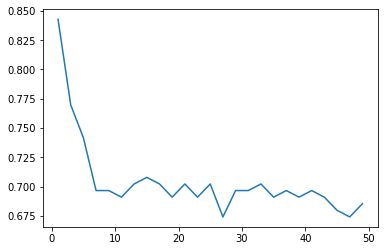

In [583]:
plt.plot(list(grid_cv.cv_results_['param_n_neighbors']),
         grid_cv.cv_results_['mean_test_score'])

### -----------------------------------------------------
# OneHot преобразование
### -----------------------------------------------------

## От числа соседей

In [588]:
grid_param = {
    "n_neighbors": [1, 2, 3, 5, 7, 9],
    "distance_name": ["euclidean", "manhattan", "chebyshev"],
    "kernel_name": ["uniform", "triangular", "epanechnikov", "quartic", "triweight",
                    "tricube", "gaussian", "cosine", "logistic", "sigmoid"],
    "encoding": ["hot"],
    "win_type": ["variable"]
}

In [589]:
from sklearn import model_selection
import sklearn.metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import make_scorer

scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average='macro') #weighted
grid_cv = model_selection.GridSearchCV(
    MyKnn(),
    grid_param,
    n_jobs=-1,
    scoring=scorer,
    cv=LeaveOneOut())

In [590]:
%%time
grid_cv.fit(X, Y)

CPU times: user 20.1 s, sys: 385 ms, total: 20.5 s
Wall time: 21.4 s


GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='cosine', n_neighbors=5,
                             win_type='fixed'),
             iid='deprecated', n_jobs=-1,
             param_grid={'distance_name': ['euclidean', 'manhattan',
                                           'chebyshev'],
                         'encoding': ['hot'],
                         'kernel_name': ['uniform', 'triangular',
                                         'epanechnikov', 'quartic', 'triweight',
                                         'tricube', 'gaussian', 'cosine',
                                         'logistic', 'sigmoid'],
                         'n_neighbors': [1, 2, 3, 5, 7, 9],
                         'win_type': ['variable']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=0)

In [515]:
grid_cv.best_params_
grid_cv.best_score_

{'distance_name': 'euclidean',
 'encoding': 'hot',
 'kernel_name': 'logistic',
 'n_neighbors': 1,
 'win_type': 'variable'}

0.9943820224719101

## От ширины окна

In [591]:
grid_param = {
    "n_neighbors": np.arange(0.05, 0.5, 0.05),
    "distance_name": ["euclidean", "manhattan", "chebyshev"],
    "kernel_name": ["uniform", "triangular", "epanechnikov", "quartic", "triweight",
                    "tricube", "gaussian", "cosine", "logistic", "sigmoid"],
    "encoding": ["hot"],
    "win_type": ["fixed"]
}

In [592]:
from sklearn import model_selection
import sklearn.metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import make_scorer

scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average='macro') #weighted
grid_cv = model_selection.GridSearchCV(
    MyKnn(),
    grid_param,
#     n_jobs=-1,
    scoring=scorer,
    cv=LeaveOneOut())

In [593]:
%%time
grid_cv.fit(X, Y)

params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, hot, fixed]
params=[0.05, euclidean, uniform, 

params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.1, euclidean, uniform, hot, fixed]
params=[0.

params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000002, euclidean, uniform, hot, fixed]
params=[0.15000000000000

params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.2, euclidean, uniform, hot, fixed]
params=[0.

params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.25, euclidean, uniform, hot, fixed]
params=[0.3, euclidean, uniform, hot, fixed]
params=[0.3, euclidean, uniform, hot, fixed]
params=[0.3, euclidean, uniform, hot

params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000003, euclidean, uniform, hot, fixed]
params=[0.35000000000000

params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.4, euclidean, uniform, hot, fixed]
params=[0.

params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, hot, fixed]
params=[0.45, euclidean, uniform, 

params=[0.05, euclidean, triangular, hot, fixed]
params=[0.05, euclidean, triangular, hot, fixed]
params=[0.05, euclidean, triangular, hot, fixed]
params=[0.05, euclidean, triangular, hot, fixed]
params=[0.05, euclidean, triangular, hot, fixed]
params=[0.05, euclidean, triangular, hot, fixed]
params=[0.05, euclidean, triangular, hot, fixed]
params=[0.05, euclidean, triangular, hot, fixed]
params=[0.05, euclidean, triangular, hot, fixed]
params=[0.05, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triangular, hot, fixed]
params=[0.1, euclidean, triang

params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, triangular, hot, fixed]
params=[0.15000000000000002, euclidean, 

params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot, fixed]
params=[0.2, euclidean, triangular, hot,

params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclidean, triangular, hot, fixed]
params=[0.25, euclid

params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot, fixed]
params=[0.3, euclidean, triangular, hot,

params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, triangular, hot, fixed]
params=[0.35000000000000003, euclidean, 

params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot, fixed]
params=[0.4, euclidean, triangular, hot,

params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclidean, triangular, hot, fixed]
params=[0.45, euclid

params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanechnikov, hot, fixed]
params=[0.05, euclidean, epanec

params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]
params=[0.1, euclidean, epanechnikov, hot, fixed]


params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.15000000000000002, euclidean, epanechnikov, hot, fixed]
params=[0.

params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]
params=[0.2, euclidean, epanechnikov, hot, fixed]


params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanechnikov, hot, fixed]
params=[0.25, euclidean, epanec

params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]
params=[0.3, euclidean, epanechnikov, hot, fixed]


params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.35000000000000003, euclidean, epanechnikov, hot, fixed]
params=[0.

params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]
params=[0.4, euclidean, epanechnikov, hot, fixed]


params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanechnikov, hot, fixed]
params=[0.45, euclidean, epanec

params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, hot, fixed]
params=[0.05, euclidean, quartic, 

params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.1, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.1500000000

params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000002, euclidean, quartic, hot, fixed]
params=[0.15000000000000

params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, hot, fixed]
params=[0.25, euclidean, quartic, 

params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.3, euclidean, quartic, hot, fixed]
params=[0.

params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000003, euclidean, quartic, hot, fixed]
params=[0.35000000000000

params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.4, euclidean, quartic, hot, fixed]
params=[0.

params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, hot, fixed]
params=[0.45, euclidean, quartic, 

params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot, fixed]
params=[0.05, euclidean, triweight, hot,

params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, euclidean, triweight, hot, fixed]
params=[0.1, 

params=[0.15000000000000002, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixed]
params=[0.2, euclidean, triweight, hot, fixe

params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot, fixed]
params=[0.25, euclidean, triweight, hot,

params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, euclidean, triweight, hot, fixed]
params=[0.3, 

params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot, fixed]
params=[0.35000000000000003, euclidean, triweight, hot,

params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, euclidean, triweight, hot, fixed]
params=[0.4, 

params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot, fixed]
params=[0.45, euclidean, triweight, hot,

params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, hot, fixed]
params=[0.05, euclidean, tricube, 

params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000002, euclidean, tricube, hot, fixed]
params=[0.15000000000000

params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.2, euclidean, tricube, hot, fixed]
params=[0.

params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, hot, fixed]
params=[0.25, euclidean, tricube, 

params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.3, euclidean, tricube, hot, fixed]
params=[0.

params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000003, euclidean, tricube, hot, fixed]
params=[0.35000000000000

params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.4, euclidean, tricube, hot, fixed]
params=[0.

params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, hot, fixed]
params=[0.45, euclidean, tricube, 

params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05, euclidean, gaussian, hot, fixed]
params=[0.05,

params=[0.1, euclidean, gaussian, hot, fixed]
params=[0.1, euclidean, gaussian, hot, fixed]
params=[0.1, euclidean, gaussian, hot, fixed]
params=[0.1, euclidean, gaussian, hot, fixed]
params=[0.1, euclidean, gaussian, hot, fixed]
params=[0.1, euclidean, gaussian, hot, fixed]
params=[0.1, euclidean, gaussian, hot, fixed]
params=[0.1, euclidean, gaussian, hot, fixed]
params=[0.15000000000000002, euclidean, gaussian, hot, fixed]
params=[0.15000000000000002, euclidean, gaussian, hot, fixed]
params=[0.15000000000000002, euclidean, gaussian, hot, fixed]
params=[0.15000000000000002, euclidean, gaussian, hot, fixed]
params=[0.15000000000000002, euclidean, gaussian, hot, fixed]
params=[0.15000000000000002, euclidean, gaussian, hot, fixed]
params=[0.15000000000000002, euclidean, gaussian, hot, fixed]
params=[0.15000000000000002, euclidean, gaussian, hot, fixed]
params=[0.15000000000000002, euclidean, gaussian, hot, fixed]
params=[0.15000000000000002, euclidean, gaussian, hot, fixed]
params=[0.15

params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, hot, fixed]
params=[0.2, euclidean, gaussian, 

params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25, euclidean, gaussian, hot, fixed]
params=[0.25,

params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, hot, fixed]
params=[0.3, euclidean, gaussian, 

params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[0.35000000000000003, euclidean, gaussian, hot, fixed]
params=[

params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, hot, fixed]
params=[0.4, euclidean, gaussian, 

params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45, euclidean, gaussian, hot, fixed]
params=[0.45,

params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.05, euclidean, cosine, hot, fixed]
params=[0.

params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, 

params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.15000000000000002, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2, euclidean, cosine, hot, fixed]
params=[0.2,

params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.25, euclidean, cosine, hot, fixed]
params=[0.

params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, hot, fixed]
params=[0.3, euclidean, cosine, 

params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, cosine, hot, fixed]
params=[0.35000000000000003, euclidean, 

params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, hot, fixed]
params=[0.4, euclidean, cosine, 

params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.45, euclidean, cosine, hot, fixed]
params=[0.

params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05, euclidean, logistic, hot, fixed]
params=[0.05,

params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, hot, fixed]
params=[0.1, euclidean, logistic, 

params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[0.15000000000000002, euclidean, logistic, hot, fixed]
params=[

params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, hot, fixed]
params=[0.2, euclidean, logistic, 

params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25, euclidean, logistic, hot, fixed]
params=[0.25,

params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.3, euclidean, logistic, hot, fixed]
params=[0.35000000000000003, euclidean, logistic, hot, fixed]
params=[0.35000000000000003, euclidean, logistic, hot, fixed]
params=[0.35000000000000003, euclidean, logistic, hot, fixed]
params=[0.35000000000000003, euclidean, logistic, hot, fixed]
params=[0.35000000000000003, euclidean, logistic, hot, fixed]
params=[0.35000000000000003, euclidean, logistic, hot, fixed]
params=[0.35000000000000003, e

params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, hot, fixed]
params=[0.4, euclidean, logistic, 

params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45, euclidean, logistic, hot, fixed]
params=[0.45,

params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, hot, fixed]
params=[0.05, euclidean, sigmoid, 

params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.1, euclidean, sigmoid, hot, fixed]
params=[0.

params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000002, euclidean, sigmoid, hot, fixed]
params=[0.15000000000000

params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.2, euclidean, sigmoid, hot, fixed]
params=[0.

params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, hot, fixed]
params=[0.25, euclidean, sigmoid, 

params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.3, euclidean, sigmoid, hot, fixed]
params=[0.

params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000003, euclidean, sigmoid, hot, fixed]
params=[0.35000000000000

params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.4, euclidean, sigmoid, hot, fixed]
params=[0.45, euclidean, sigmoid, hot, fixed]
params=[0.45, euclidean, sigmoid, hot, fixed]
params=[0.45, euclidean, sigmoid, hot, fixed]
params=[0.45, euclidean, sigmoid, hot, fixed]
params=[0.45, euclidean, sigmoid, hot, fixed]
param

params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, uniform, 

params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.1, manhattan, uniform, hot, fixed]
params=[0.

params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000002, manhattan, uniform, hot, fixed]
params=[0.15000000000000

params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.2, manhattan, uniform, hot, fixed]
params=[0.

params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, hot, fixed]
params=[0.25, manhattan, uniform, 

params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.3, manhattan, uniform, hot, fixed]
params=[0.

params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000003, manhattan, uniform, hot, fixed]
params=[0.35000000000000

params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.4, manhattan, uniform, hot, fixed]
params=[0.

params=[0.45, manhattan, uniform, hot, fixed]
params=[0.45, manhattan, uniform, hot, fixed]
params=[0.45, manhattan, uniform, hot, fixed]
params=[0.45, manhattan, uniform, hot, fixed]
params=[0.45, manhattan, uniform, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular, hot, fixed]
params=[0.05, manhattan, triangular

params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot, fixed]
params=[0.1, manhattan, triangular, hot,

params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, triangular, hot, fixed]
params=[0.15000000000000002, manhattan, 

params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot, fixed]
params=[0.2, manhattan, triangular, hot,

params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhattan, triangular, hot, fixed]
params=[0.25, manhat

params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot, fixed]
params=[0.3, manhattan, triangular, hot,

params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, triangular, hot, fixed]
params=[0.35000000000000003, manhattan, 

params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot, fixed]
params=[0.4, manhattan, triangular, hot,

params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhattan, triangular, hot, fixed]
params=[0.45, manhat

params=[0.05, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]
params=[0.1, manhattan, epanechnikov, hot, fixed]

params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.15000000000000002, manhattan, epanechnikov, hot, fixed]
params=[0.

params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]
params=[0.2, manhattan, epanechnikov, hot, fixed]


params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanechnikov, hot, fixed]
params=[0.25, manhattan, epanec

params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]
params=[0.3, manhattan, epanechnikov, hot, fixed]


params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.35000000000000003, manhattan, epanechnikov, hot, fixed]
params=[0.

params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]
params=[0.4, manhattan, epanechnikov, hot, fixed]


params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanechnikov, hot, fixed]
params=[0.45, manhattan, epanec

params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, hot, fixed]
params=[0.05, manhattan, quartic, 

params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.1, manhattan, quartic, hot, fixed]
params=[0.

params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.15000000000000002, manhattan, quartic, hot, fixed]
params=[0.2, manhattan, quartic, hot, fixed]
params=[0.2, manhattan, quartic, hot, fixed]
params=[0.2, manhattan, quartic, hot, fixed]
params=[0.2, manhattan, quartic, hot, fixed]
params=[0.2, manhattan, quartic, hot, fixed]
params=[0.2, manhattan, quartic, hot, fixed

params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, hot, fixed]
params=[0.25, manhattan, quartic, 

params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.3, manhattan, quartic, hot, fixed]
params=[0.

params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000003, manhattan, quartic, hot, fixed]
params=[0.35000000000000

params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.4, manhattan, quartic, hot, fixed]
params=[0.

params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, hot, fixed]
params=[0.45, manhattan, quartic, 

params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot, fixed]
params=[0.05, manhattan, triweight, hot,

params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, manhattan, triweight, hot, fixed]
params=[0.1, 

params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot, fixed]
params=[0.15000000000000002, manhattan, triweight, hot,

params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, manhattan, triweight, hot, fixed]
params=[0.2, 

params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot, fixed]
params=[0.25, manhattan, triweight, hot,

params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, manhattan, triweight, hot, fixed]
params=[0.3, 

params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.35000000000000003, manhattan, triweight, hot, fixed]
params=[0.4, manhattan, triweight, hot, fixed]
params=[0.4, manhattan, triweight, hot, fixed]
params=[0.4, manhattan, triweight, hot, fixed]
params=[0.4, manhattan, triweight, hot, fixed]
params=[0.4, manhattan, triweight, hot, fixed]
params=[0

params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot, fixed]
params=[0.45, manhattan, triweight, hot,

params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, tricube, 

params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.1, manhattan, tricube, hot, fixed]
params=[0.

params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000002, manhattan, tricube, hot, fixed]
params=[0.15000000000000

params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.2, manhattan, tricube, hot, fixed]
params=[0.

params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, hot, fixed]
params=[0.25, manhattan, tricube, 

params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.3, manhattan, tricube, hot, fixed]
params=[0.

params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000003, manhattan, tricube, hot, fixed]
params=[0.35000000000000

params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.4, manhattan, tricube, hot, fixed]
params=[0.

params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.45, manhattan, tricube, hot, fixed]
params=[0.05, manhattan, gaussian, hot, fixed]
params=[0.05, manhattan, gaussian, hot, fixed]
params=[0.05, manhattan, gaussian, hot, fixed]
params=[0.05, manhattan, gaussi

params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, hot, fixed]
params=[0.1, manhattan, gaussian, 

params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[0.15000000000000002, manhattan, gaussian, hot, fixed]
params=[

params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, hot, fixed]
params=[0.2, manhattan, gaussian, 

params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25, manhattan, gaussian, hot, fixed]
params=[0.25,

params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, hot, fixed]
params=[0.3, manhattan, gaussian, 

params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[0.35000000000000003, manhattan, gaussian, hot, fixed]
params=[

params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, hot, fixed]
params=[0.4, manhattan, gaussian, 

params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.45, manhattan, gaussian, hot, fixed]
params=[0.05, manhattan, cosine, hot, fixed]
params=[0.05, manhattan, cosine, hot, fixed]
params=[0.05, manhattan, cosine, hot, fixed]
params=[0.05, manhattan, cosine, hot, fixed]
params=[0.05, manhattan, cosine, hot, fixed]
params=[0.05, manhattan, cosine, hot, fixed]
params=[0.05, manhattan, cosine, hot, fixed]
params=[0.05, manhattan, cosine, hot, fixed]
params=[0.05, manhattan, cosi

params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, hot, fixed]
params=[0.1, manhattan, cosine, 

params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, cosine, hot, fixed]
params=[0.15000000000000002, manhattan, 

params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, hot, fixed]
params=[0.2, manhattan, cosine, 

params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.25, manhattan, cosine, hot, fixed]
params=[0.

params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, hot, fixed]
params=[0.3, manhattan, cosine, 

params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, cosine, hot, fixed]
params=[0.35000000000000003, manhattan, 

params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, hot, fixed]
params=[0.4, manhattan, cosine, 

params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.45, manhattan, cosine, hot, fixed]
params=[0.05, manhattan, logistic, hot, fixed]
params=[0.05, manhattan, logistic, hot, fixed]
params

params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, hot, fixed]
params=[0.1, manhattan, logistic, 

params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[0.15000000000000002, manhattan, logistic, hot, fixed]
params=[

params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, hot, fixed]
params=[0.2, manhattan, logistic, 

params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25, manhattan, logistic, hot, fixed]
params=[0.25,

params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, hot, fixed]
params=[0.3, manhattan, logistic, 

params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[0.35000000000000003, manhattan, logistic, hot, fixed]
params=[

params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.4, manhattan, logistic, hot, fixed]
params=[0.45, manhattan, logistic, hot, fixed]
params=[0.45, manhattan, logistic, hot, fixed]
params=[0.45, manhattan, logistic, hot, fixed]
params=[0.45, manhattan, logist

params=[0.45, manhattan, logistic, hot, fixed]
params=[0.45, manhattan, logistic, hot, fixed]
params=[0.45, manhattan, logistic, hot, fixed]
params=[0.45, manhattan, logistic, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmoid, hot, fixed]
params=[0.05, manhattan, sigmo

params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.1, manhattan, sigmoid, hot, fixed]
params=[0.

params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000002, manhattan, sigmoid, hot, fixed]
params=[0.15000000000000

params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.2, manhattan, sigmoid, hot, fixed]
params=[0.

params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, hot, fixed]
params=[0.25, manhattan, sigmoid, 

params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.3, manhattan, sigmoid, hot, fixed]
params=[0.

params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000003, manhattan, sigmoid, hot, fixed]
params=[0.35000000000000

params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.4, manhattan, sigmoid, hot, fixed]
params=[0.

params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, hot, fixed]
params=[0.45, manhattan, sigmoid, 

params=[0.05, chebyshev, uniform, hot, fixed]
params=[0.05, chebyshev, uniform, hot, fixed]
params=[0.05, chebyshev, uniform, hot, fixed]
params=[0.05, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params=[0.1, chebyshev, uniform, hot, fixed]
params

params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000002, chebyshev, uniform, hot, fixed]
params=[0.15000000000000

params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.2, chebyshev, uniform, hot, fixed]
params=[0.

params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, hot, fixed]
params=[0.25, chebyshev, uniform, 

params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.3, chebyshev, uniform, hot, fixed]
params=[0.

params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000003, chebyshev, uniform, hot, fixed]
params=[0.35000000000000

params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.4, chebyshev, uniform, hot, fixed]
params=[0.

params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, hot, fixed]
params=[0.45, chebyshev, uniform, 

params=[0.05, chebyshev, triangular, hot, fixed]
params=[0.05, chebyshev, triangular, hot, fixed]
params=[0.05, chebyshev, triangular, hot, fixed]
params=[0.05, chebyshev, triangular, hot, fixed]
params=[0.05, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular, hot, fixed]
params=[0.1, chebyshev, triangular,

params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, triangular, hot, fixed]
params=[0.15000000000000002, chebyshev, 

params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot, fixed]
params=[0.2, chebyshev, triangular, hot,

params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebyshev, triangular, hot, fixed]
params=[0.25, chebys

params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot, fixed]
params=[0.3, chebyshev, triangular, hot,

params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, triangular, hot, fixed]
params=[0.35000000000000003, chebyshev, 

params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot, fixed]
params=[0.4, chebyshev, triangular, hot,

params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanechnikov, hot, fixed]
params=[0.05, chebyshev, epanec

params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]
params=[0.1, chebyshev, epanechnikov, hot, fixed]


params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.15000000000000002, chebyshev, epanechnikov, hot, fixed]
params=[0.

params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]
params=[0.2, chebyshev, epanechnikov, hot, fixed]


params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanechnikov, hot, fixed]
params=[0.25, chebyshev, epanec

params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]
params=[0.3, chebyshev, epanechnikov, hot, fixed]


params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.35000000000000003, chebyshev, epanechnikov, hot, fixed]
params=[0.

params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]
params=[0.4, chebyshev, epanechnikov, hot, fixed]


params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanechnikov, hot, fixed]
params=[0.45, chebyshev, epanec

params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, hot, fixed]
params=[0.05, chebyshev, quartic, 

params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.1, chebyshev, quartic, hot, fixed]
params=[0.

params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000002, chebyshev, quartic, hot, fixed]
params=[0.15000000000000

params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.2, chebyshev, quartic, hot, fixed]
params=[0.25, chebyshev, quartic, hot, fixed]
params=[0.25, chebyshev, quartic, hot, fixed]
params=[

params=[0.25, chebyshev, quartic, hot, fixed]
params=[0.25, chebyshev, quartic, hot, fixed]
params=[0.25, chebyshev, quartic, hot, fixed]
params=[0.25, chebyshev, quartic, hot, fixed]
params=[0.25, chebyshev, quartic, hot, fixed]
params=[0.25, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
params=[0.3, chebyshev, quartic, hot, fixed]
para

params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000003, chebyshev, quartic, hot, fixed]
params=[0.35000000000000

params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.4, chebyshev, quartic, hot, fixed]
params=[0.

params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, hot, fixed]
params=[0.45, chebyshev, quartic, 

params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot, fixed]
params=[0.05, chebyshev, triweight, hot,

params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, chebyshev, triweight, hot, fixed]
params=[0.1, 

params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot, fixed]
params=[0.15000000000000002, chebyshev, triweight, hot,

params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, chebyshev, triweight, hot, fixed]
params=[0.2, 

params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot, fixed]
params=[0.25, chebyshev, triweight, hot,

params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, chebyshev, triweight, hot, fixed]
params=[0.3, 

params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot, fixed]
params=[0.35000000000000003, chebyshev, triweight, hot,

params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, chebyshev, triweight, hot, fixed]
params=[0.4, 

params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot, fixed]
params=[0.45, chebyshev, triweight, hot,

params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.05, chebyshev, tricube, hot, fixed]
params=[0.1, chebyshev, tricube, hot, fixed]
params=[0.1, chebyshev, tricube, hot, fixed]
params=[0.1, chebyshev, tricube, hot, fixed]
params=[0.1, chebyshev, tricube, hot, fixed]
params=[0.1, chebyshev, tricube, hot, fixed]
params=[0.1, chebyshev, tricube, hot, fixed]
params=[0.1, chebyshev, tricube, hot, fixed]
params=[0.1, chebyshev, tricube, hot, fix

params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000002, chebyshev, tricube, hot, fixed]
params=[0.15000000000000

params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.2, chebyshev, tricube, hot, fixed]
params=[0.

params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, hot, fixed]
params=[0.25, chebyshev, tricube, 

params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.3, chebyshev, tricube, hot, fixed]
params=[0.

params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000003, chebyshev, tricube, hot, fixed]
params=[0.35000000000000

params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.4, chebyshev, tricube, hot, fixed]
params=[0.

params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, hot, fixed]
params=[0.45, chebyshev, tricube, 

params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05, chebyshev, gaussian, hot, fixed]
params=[0.05,

params=[0.1, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000002, chebyshev, gaussian, hot, fixed]
params=[0.15000000000000

params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, hot, fixed]
params=[0.2, chebyshev, gaussian, 

params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25, chebyshev, gaussian, hot, fixed]
params=[0.25,

params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, hot, fixed]
params=[0.3, chebyshev, gaussian, 

params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[0.35000000000000003, chebyshev, gaussian, hot, fixed]
params=[

params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, hot, fixed]
params=[0.4, chebyshev, gaussian, 

params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45, chebyshev, gaussian, hot, fixed]
params=[0.45,

params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.05, chebyshev, cosine, hot, fixed]
params=[0.

params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, hot, fixed]
params=[0.1, chebyshev, cosine, 

params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, cosine, hot, fixed]
params=[0.15000000000000002, chebyshev, 

params=[0.2, chebyshev, cosine, hot, fixed]
params=[0.2, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25, chebyshev, cosine, hot, fixed]
params=[0.25

params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, hot, fixed]
params=[0.3, chebyshev, cosine, 

params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, cosine, hot, fixed]
params=[0.35000000000000003, chebyshev, 

params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, hot, fixed]
params=[0.4, chebyshev, cosine, 

params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.45, chebyshev, cosine, hot, fixed]
params=[0.

params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05, chebyshev, logistic, hot, fixed]
params=[0.05,

params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.1, chebyshev, logistic, hot, fixed]
params=[0.15000000000000002, chebyshev, logistic, hot, fixed]
params=[0.15000000000000002, chebyshev, logistic, hot, fixed]
params=[0.15000000000000002, chebyshev, logistic, hot, fixed]
params=[0.15000000000000002, chebyshev, logistic, hot, fixed]
params=[0.15000000000000002, chebyshev, logistic, hot, fixed]
params=[0.15000000000000002, chebyshev, logistic, hot, fixed]
params=[0.15000000000000002, c

params=[0.15000000000000002, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, chebyshev, logistic, hot, fixed]
params=[0.2, cheby

params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25, chebyshev, logistic, hot, fixed]
params=[0.25,

params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, hot, fixed]
params=[0.3, chebyshev, logistic, 

params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[0.35000000000000003, chebyshev, logistic, hot, fixed]
params=[

params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, hot, fixed]
params=[0.4, chebyshev, logistic, 

params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45, chebyshev, logistic, hot, fixed]
params=[0.45,

params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, hot, fixed]
params=[0.05, chebyshev, sigmoid, 

params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.1, chebyshev, sigmoid, hot, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, hot, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, hot, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, hot, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, hot, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, hot, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, hot, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, hot, fixed]
params=[0.15000000000000002, chebyshev, sigmoid, hot, fixed]
params=[0.1500000

params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.2, chebyshev, sigmoid, hot, fixed]
params=[0.

params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, hot, fixed]
params=[0.25, chebyshev, sigmoid, 

params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.3, chebyshev, sigmoid, hot, fixed]
params=[0.

params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000003, chebyshev, sigmoid, hot, fixed]
params=[0.35000000000000

params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.4, chebyshev, sigmoid, hot, fixed]
params=[0.

params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, hot, fixed]
params=[0.45, chebyshev, sigmoid, 

GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='cosine', n_neighbors=5,
                             win_type='fixed'),
             iid='deprecated', n_jobs=None,
             param_grid={'distance_name': ['euclidean', 'manhattan',
                                           'chebyshev'],
                         'encoding': ['hot'],
                         'kernel_name': ['uniform', 'triangular',
                                         'epanechnikov', 'quartic', 'triweight',
                                         'tricube', 'gaussian', 'cosine',
                                         'logistic', 'sigmoid'],
                         'n_neighbors': array([0.05000, 0.10000, 0.15000, 0.20000, 0.25000, 0.30000, 0.35000,
       0.40000, 0.45000]),
                         'win_type': ['fixed']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,


In [594]:
grid_cv.best_params_
grid_cv.best_score_

{'distance_name': 'manhattan',
 'encoding': 'hot',
 'kernel_name': 'gaussian',
 'n_neighbors': 0.15000000000000002,
 'win_type': 'fixed'}

0.9831460674157303

## Лучшие параметры

In [596]:
grid_param = {
    "n_neighbors": np.arange(1, 50, 2),
    "distance_name": ["euclidean"],
    "kernel_name": ["logistic"],
    "encoding": ["hot"],
    "win_type": ["variable"]
}

In [597]:
from sklearn import model_selection
import sklearn.metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import make_scorer

scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average='macro') #weighted
grid_cv = model_selection.GridSearchCV(
    MyKnn(),
    grid_param,
#     n_jobs=-1,
    scoring=scorer,
    cv=LeaveOneOut())

In [598]:
%%time
grid_cv.fit(X, Y)

params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, euclidean, logistic, hot, variable]
params=[1, eu

params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, euclidean, logistic, hot, variable]
params=[3, eu

params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, euclidean, logistic, hot, variable]
params=[5, eu

params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, euclidean, logistic, hot, variable]
params=[7, eu

params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, euclidean, logistic, hot, variable]
params=[9, eu

params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, variable]
params=[11, euclidean, logistic, hot, va

params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, variable]
params=[13, euclidean, logistic, hot, va

params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, variable]
params=[15, euclidean, logistic, hot, va

params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, variable]
params=[17, euclidean, logistic, hot, va

params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[19, euclidean, logistic, hot, variable]
params=[21, euclidean, logistic, hot, va

params=[21, euclidean, logistic, hot, variable]
params=[21, euclidean, logistic, hot, variable]
params=[21, euclidean, logistic, hot, variable]
params=[21, euclidean, logistic, hot, variable]
params=[21, euclidean, logistic, hot, variable]
params=[21, euclidean, logistic, hot, variable]
params=[21, euclidean, logistic, hot, variable]
params=[21, euclidean, logistic, hot, variable]
params=[21, euclidean, logistic, hot, variable]
params=[21, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, variable]
params=[23, euclidean, logistic, hot, va

params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, variable]
params=[25, euclidean, logistic, hot, va

params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, variable]
params=[27, euclidean, logistic, hot, va

params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, variable]
params=[29, euclidean, logistic, hot, va

params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, variable]
params=[31, euclidean, logistic, hot, va

params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, variable]
params=[33, euclidean, logistic, hot, va

params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, variable]
params=[35, euclidean, logistic, hot, va

params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, variable]
params=[39, euclidean, logistic, hot, va

params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, variable]
params=[41, euclidean, logistic, hot, va

params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, variable]
params=[43, euclidean, logistic, hot, va

params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, variable]
params=[45, euclidean, logistic, hot, va

params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, variable]
params=[47, euclidean, logistic, hot, va

params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, variable]
params=[49, euclidean, logistic, hot, va

GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='cosine', n_neighbors=5,
                             win_type='fixed'),
             iid='deprecated', n_jobs=None,
             param_grid={'distance_name': ['euclidean'], 'encoding': ['hot'],
                         'kernel_name': ['logistic'],
                         'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49]),
                         'win_type': ['variable']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=0)

In [599]:
grid_cv.best_params_
grid_cv.best_score_

{'distance_name': 'euclidean',
 'encoding': 'hot',
 'kernel_name': 'logistic',
 'n_neighbors': 1,
 'win_type': 'variable'}

0.9943820224719101

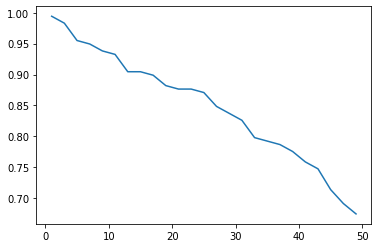

In [600]:
plt.plot(list(grid_cv.cv_results_['param_n_neighbors']),
         grid_cv.cv_results_['mean_test_score'])

##  Модель из библиотеки sklearn

In [495]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [601]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
grid_param_std = {
    'n_neighbors': np.arange(1, 50, 2),
    'p': [1, 2],
}

grid_cv = model_selection.GridSearchCV(KNeighborsClassifier(),
                                       grid_param_std,
                                       scoring=scorer,
                                       cv=LeaveOneOut())

In [602]:
grid_cv.fit(X, Y)
grid_cv.best_params_
grid_cv.best_score_

GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49]),
                         'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=0)

{'n_neighbors': 1, 'p': 1}

0.9775280898876404

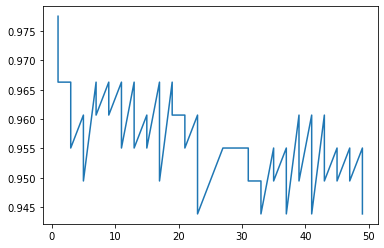

In [605]:
plt.plot(list(grid_cv.cv_results_['param_n_neighbors']),
         grid_cv.cv_results_['mean_test_score'])

In [603]:
grid_cv.cv_results_

{'mean_fit_time': array([0.00056, 0.00054, 0.00062, 0.00058, 0.00059, 0.00058, 0.00060,
        0.00054, 0.00056, 0.00054, 0.00054, 0.00053, 0.00053, 0.00053,
        0.00053, 0.00054, 0.00058, 0.00056, 0.00053, 0.00058, 0.00059,
        0.00057, 0.00054, 0.00053, 0.00057, 0.00053, 0.00055, 0.00053,
        0.00057, 0.00055, 0.00055, 0.00054, 0.00055, 0.00054, 0.00055,
        0.00053, 0.00053, 0.00055, 0.00055, 0.00056, 0.00053, 0.00053,
        0.00053, 0.00053, 0.00053, 0.00053, 0.00053, 0.00054, 0.00053,
        0.00053]),
 'std_fit_time': array([0.00019, 0.00006, 0.00012, 0.00011, 0.00011, 0.00009, 0.00011,
        0.00005, 0.00008, 0.00005, 0.00007, 0.00004, 0.00005, 0.00004,
        0.00005, 0.00006, 0.00011, 0.00007, 0.00005, 0.00008, 0.00010,
        0.00008, 0.00006, 0.00005, 0.00008, 0.00005, 0.00007, 0.00005,
        0.00007, 0.00005, 0.00007, 0.00006, 0.00006, 0.00007, 0.00006,
        0.00005, 0.00005, 0.00008, 0.00007, 0.00007, 0.00004, 0.00004,
        0.00004, 0.00005,